## Ensemble learning

# vocal extraction using LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusted X shape: (9986, 40, 132)
X_train shape: (6990, 40, 132), X_val shape: (1498, 40, 132), X_test shape: (1498, 40, 132)
Building and training LSTM vocal classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 40, 512)        │       796,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,266 (9.69 MB)

 Trainable params: 2,540,266 (9.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.1209 - loss: 2.3249 - val_accuracy: 0.3184 - val_loss: 2.1673 - learning_rate: 1.0000e-04
Epoch 2/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1816 - loss: 2.2045 - val_accuracy: 0.3805 - val_loss: 2.0045 - learning_rate: 1.0000e-04
Epoch 3/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2236 - loss: 2.1037 - val_accuracy: 0.3965 - val_loss: 1.8722 - learning_rate: 1.0000e-04
Epoch 4/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2786 - loss: 2.0210 - val_accuracy: 0.4226 - val_loss: 1.7770 - learning_rate: 1.0000e-04
Epoch 5/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3066 - loss: 1.9277 - val_accuracy: 0.4806 - val_loss: 1.6952 - learning_rate: 1.0000e-04
Epoch 6/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3362 - loss: 1.8676 - val_accuracy: 0.4927 - val_loss: 1.6573 - learning_rate: 1.0000e-04
Epoch 7/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/ste

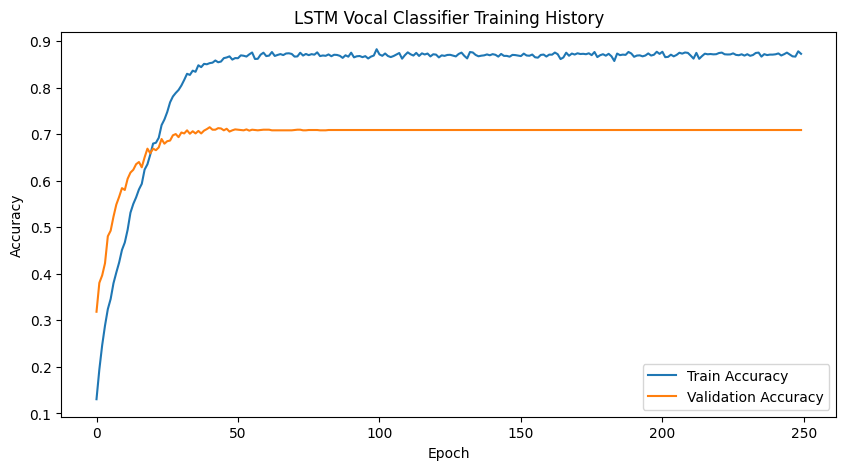

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


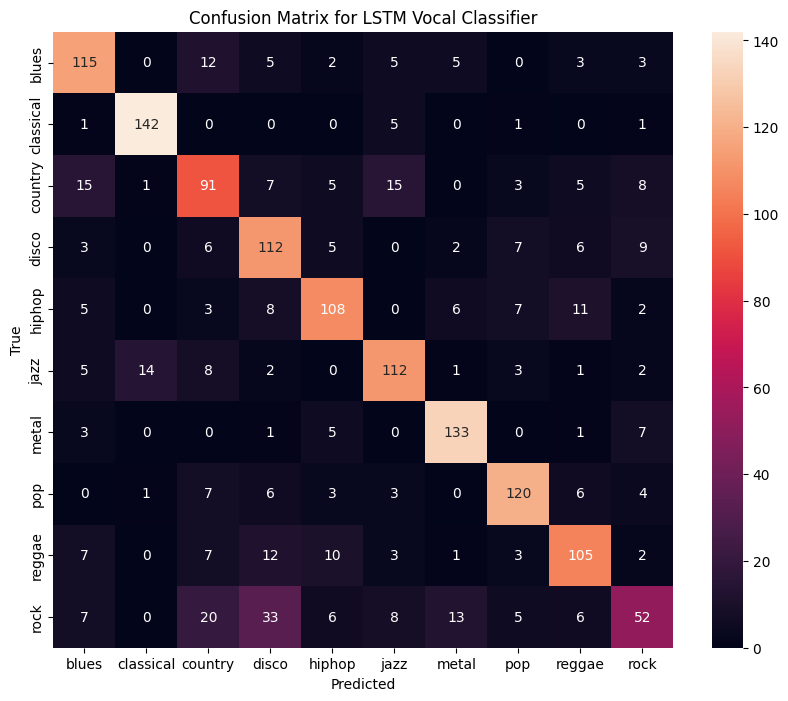

LSTM model saved to /content/drive/MyDrive/lstm_vocal_classifier.keras


In [ ]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
import librosa
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Disable mixed precision for CPU compatibility
tf.keras.mixed_precision.set_global_policy('float32')

# Parameters
batch_size = 64
data_path = '/content/drive/MyDrive/data.json'  # Path to data.json
model_save_path = '/content/drive/MyDrive/lstm_vocal_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40  # Paper uses 40 MFCCs
n_frames = 132  # Paper expects 132 frames for 3-second segments

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Handle MFCC shape mismatch
if X.shape[1:] == (130, 13):
    print(f"Warning: MFCC shape {X.shape[1:]} does not match expected (40, 132). Attempting to fix...")
    # Option 1: Pad MFCCs to (40, 132)
    if X.shape[1] > 40:
        X = X[:, :40, :]  # Truncate to 40 coefficients
    else:
        X = np.pad(X, ((0, 0), (0, 40 - X.shape[1]), (0, 0)), mode='constant')
    if X.shape[2] < 132:
        X = np.pad(X, ((0, 0), (0, 0), (0, 132 - X.shape[2])), mode='constant')
    print(f"Adjusted X shape: {X.shape}")
else:
    print(f"Unexpected MFCC shape {X.shape[1:]}. Please verify data.json or provide raw audio for re-extraction.")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define LSTM model (from paper)
def build_lstm_vocal_classifier(input_shape=(40, 132), num_classes=10):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(256)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    return model

# Build and compile model
print("Building and training LSTM vocal classifier...")
lstm_model = build_lstm_vocal_classifier(input_shape=(40, 132))
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model
history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = lstm_model.evaluate(test_dataset)
print(f"LSTM Vocal Classifier Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Vocal Classifier Training History')
plt.show()

# Generate confusion matrix
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Vocal Classifier')
plt.show()

# Save model
lstm_model.save(model_save_path)
print(f"LSTM model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusting MFCCs for LSTM to (40, 132)...
LSTM X shape: (9986, 40, 132)
CRNN X shape: (9986, 130, 13, 1)
LSTM X_train shape: (6990, 40, 132), X_val shape: (1498, 40, 132), X_test shape: (1498, 40, 132)
CRNN X_train shape: (6990, 130, 13, 1), X_crnn_val shape: (1498, 130, 13, 1), X_crnn_test shape: (1498, 130, 13, 1)
Loading trained LSTM model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7264 - loss: 1.4284
LSTM Vocal Classifier Test Loss: 1.3550, Accuracy: 0.7276
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


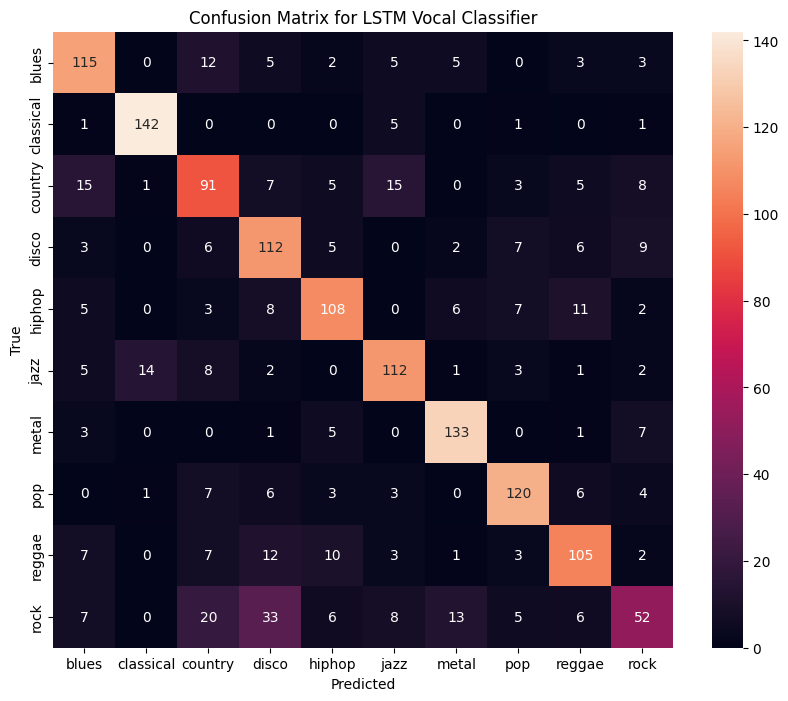

In [ ]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '/content/drive/MyDrive/data.json'
model_save_path = '/content/drive/MyDrive/lstm_vocal_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40
n_frames = 132

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Prepare MFCCs for LSTM (pad to (40, 132))
X_lstm = X.copy()
if X_lstm.shape[1:] == (130, 13):
    print(f"Adjusting MFCCs for LSTM to (40, 132)...")
    X_lstm = X_lstm[:, :40, :]  # Truncate to 40 coefficients
    X_lstm = np.pad(X_lstm, ((0, 0), (0, 0), (0, 132 - X_lstm.shape[2])), mode='constant')
    print(f"LSTM X shape: {X_lstm.shape}")
elif X_lstm.shape[1:] != (40, 132):
    print(f"Warning: LSTM input shape is {X_lstm.shape[1:]}, expected (40, 132). Model loading might fail.")


# Prepare MFCCs for CRNN (keep original (130, 13))
X_crnn = X[..., np.newaxis]  # Add channel dimension
print(f"CRNN X shape: {X_crnn.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_lstm_train, X_lstm_temp, y_train, y_temp = train_test_split(X_lstm, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_lstm_val, X_lstm_test, y_val, y_test = train_test_split(X_lstm_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_crnn_train, X_crnn_temp = train_test_split(X_crnn, test_size=0.3, random_state=42)
X_crnn_val, X_crnn_test = train_test_split(X_crnn_temp, test_size=0.5, random_state=42)
print(f"LSTM X_train shape: {X_lstm_train.shape}, X_val shape: {X_lstm_val.shape}, X_test shape: {X_lstm_test.shape}")
print(f"CRNN X_train shape: {X_crnn_train.shape}, X_crnn_val shape: {X_crnn_val.shape}, X_crnn_test shape: {X_crnn_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
crnn_test_dataset = tf.data.Dataset.from_tensor_slices((X_crnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Define LSTM model (This function is here for reference, not used for loading)
def build_lstm_vocal_classifier(input_shape=(40, 132), num_classes=10):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(256)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Removed dtype='float32' here as it's not needed for Sequential API's output layer
    ])
    return model

# Load and evaluate LSTM model (already trained)
print("Loading trained LSTM model...")
# Attempt to load the model
try:
    lstm_model = tf.keras.models.load_model(model_save_path)
    lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(test_dataset)
    print(f"LSTM Vocal Classifier Test Loss: {lstm_test_loss:.4f}, Accuracy: {lstm_test_accuracy:.4f}")

    # Generate LSTM confusion matrix
    y_pred_lstm = lstm_model.predict(X_lstm_test)
    y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_lstm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for LSTM Vocal Classifier')
    plt.show()

except Exception as e:
    print(f"Error loading or evaluating LSTM model: {e}")
    print("This might be due to a version mismatch between Keras versions used for saving and loading.")
    print("Consider retraining the model with the current Keras version or inspecting the saved model file structure.")

# Accompainment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusting MFCCs for CNN to (40, 132)...
CNN X shape: (9986, 40, 132, 1)
CRNN X shape: (9986, 130, 13, 1)
CNN X_train shape: (6990, 40, 132, 1), X_val shape: (1498, 40, 132, 1), X_test shape: (1498, 40, 132, 1)
CRNN X_train shape: (6990, 130, 13, 1), X_val shape: (1498, 130, 13, 1), X_crnn_test shape: (1498, 130, 13, 1)
Building and training CNN accompaniment classifier...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 40, 132, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 66, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 66, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 66, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 10, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 16, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,622,474 (10.00 MB)

 Trainable params: 2,622,474 (10.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2208 - loss: 2.1218 - val_accuracy: 0.4386 - val_loss: 1.6340 - learning_rate: 1.0000e-04
Epoch 2/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3659 - loss: 1.7531 - val_accuracy: 0.4720 - val_loss: 1.5098 - learning_rate: 1.0000e-04
Epoch 3/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4248 - loss: 1.6201 - val_accuracy: 0.5027 - val_loss: 1.4087 - learning_rate: 1.0000e-04
Epoch 4/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4577 - loss: 1.5108 - val_accuracy: 0.5254 - val_loss: 1.3453 - learning_rate: 1.0000e-04
Epoch 5/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4926 - loss: 1.4267 - val_accuracy: 0.5320 - val_loss: 1.3121 - learning_rate: 1.0000e-04
Epoch 6/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5177 - loss: 1.3720 - val_accuracy: 0.5607 - val_loss: 1.2368 - learning_rate: 1.0000e-04
Epoch 7/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/st

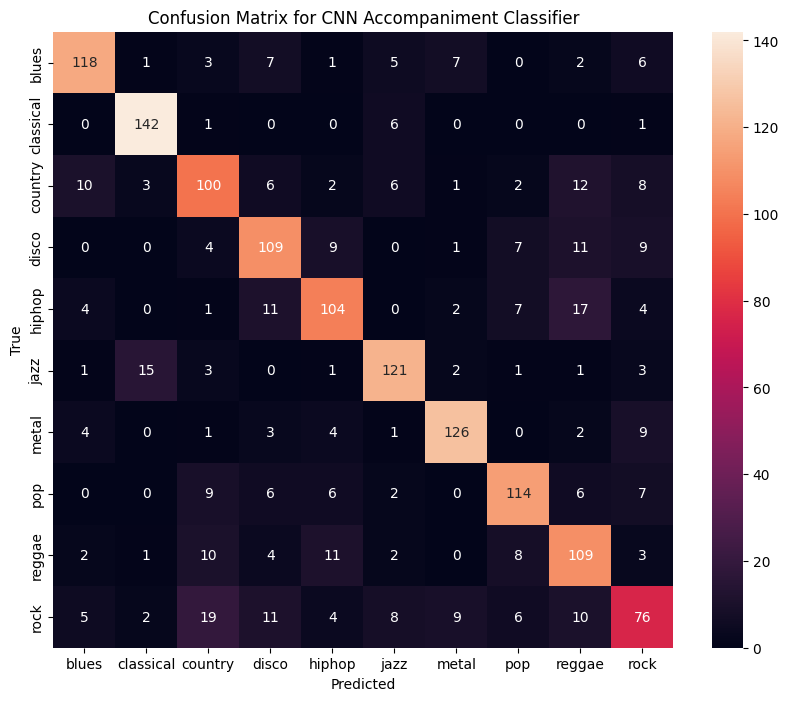

CNN model saved to /content/drive/MyDrive/cnn_accompaniment_classifier.keras
Loading and evaluating pre-trained CRNN model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1090 - loss: 7.3562
CRNN Test Loss: 7.3968, Accuracy: 0.0988
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


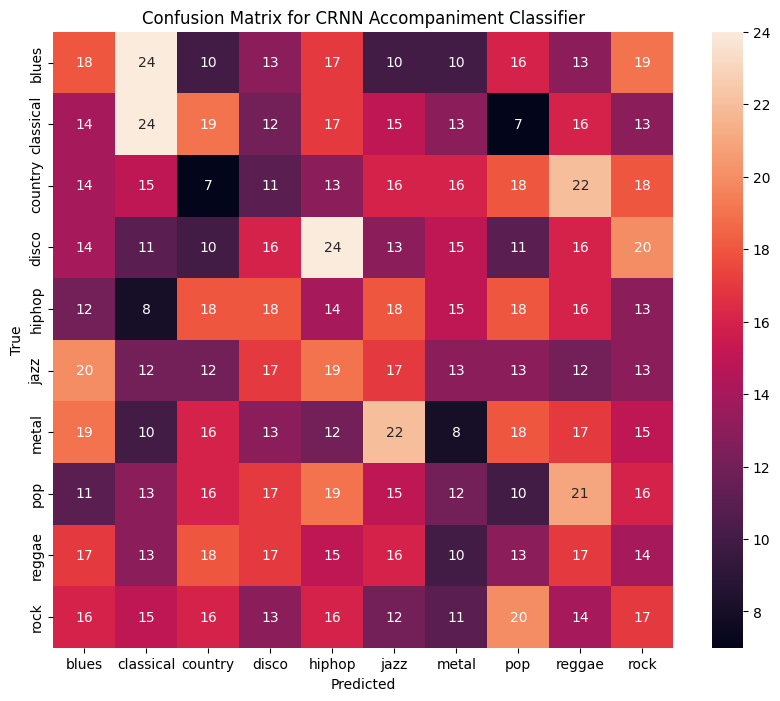

In [5]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
import librosa
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '/content/drive/MyDrive/data.json'
cnn_model_save_path = '/content/drive/MyDrive/cnn_accompaniment_classifier.keras'
crnn_model_path = '/content/drive/MyDrive/crnn.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40
n_frames = 132

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    # Changed fused() to json.load(f)
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
# Corrected variable name mm_ccs to mfccs
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Prepare MFCCs for CNN (pad to (40, 132, 1))
X_cnn = X.copy()
if X_cnn.shape[1:] == (130, 13):
    print(f"Adjusting MFCCs for CNN to (40, 132)...")
    X_cnn = X_cnn[:, :40, :]  # Truncate to 40 coefficients
    X_cnn = np.pad(X_cnn, ((0, 0), (0, 0), (0, 132 - X_cnn.shape[2])), mode='constant')
    X_cnn = X_cnn[..., np.newaxis]  # Add channel dimension
    print(f"CNN X shape: {X_cnn.shape}")

# Prepare MFCCs for CRNN (keep original (130, 13, 1))
X_crnn = X[..., np.newaxis]
print(f"CRNN X shape: {X_crnn.shape}")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_cnn_train, X_cnn_temp, y_train, y_temp = train_test_split(X_cnn, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_cnn_val, X_cnn_test, y_val, y_test = train_test_split(X_cnn_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_crnn_train, X_crnn_temp = train_test_split(X_crnn, test_size=0.3, random_state=42)
X_crnn_val, X_crnn_test = train_test_split(X_crnn_temp, test_size=0.5, random_state=42)
print(f"CNN X_train shape: {X_cnn_train.shape}, X_val shape: {X_cnn_val.shape}, X_test shape: {X_cnn_test.shape}")
print(f"CRNN X_train shape: {X_crnn_train.shape}, X_val shape: {X_crnn_val.shape}, X_crnn_test shape: {X_crnn_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
crnn_test_dataset = tf.data.Dataset.from_tensor_slices((X_crnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define CNN model (from paper)
def build_cnn_accompaniment_classifier(input_shape=(40, 132, 1), num_classes=10):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile CNN model
print("Building and training CNN accompaniment classifier...")
cnn_model = build_cnn_accompaniment_classifier()
cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train CNN model
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_dataset)
print(f"CNN Accompaniment Classifier Test Loss: {cnn_test_loss:.4f}, Accuracy: {cnn_test_accuracy:.4f}")

# Generate CNN confusion matrix
y_pred_cnn = cnn_model.predict(X_cnn_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN Accompaniment Classifier')
plt.show()

# Save CNN model
cnn_model.save(cnn_model_save_path)
print(f"CNN model saved to {cnn_model_save_path}")

# Evaluate CRNN model
if os.path.exists(crnn_model_path):
    print("Loading and evaluating pre-trained CRNN model...")
    try:
        crnn_model = tf.keras.models.load_model(crnn_model_path)
        crnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
        crnn_test_loss, crnn_test_accuracy = crnn_model.evaluate(crnn_test_dataset)
        print(f"CRNN Test Loss: {crnn_test_loss:.4f}, Accuracy: {crnn_test_accuracy:.4f}")

        # Generate CRNN confusion matrix
        y_pred_crnn = crnn_model.predict(X_crnn_test)
        y_pred_crnn_classes = np.argmax(y_pred_crnn, axis=1)
        cm_crnn = confusion_matrix(y_test, y_pred_crnn_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_crnn, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for CRNN Accompaniment Classifier')
        plt.show()
    except Exception as e:
        print(f"Error evaluating CRNN model: {e}")
else:
    print("CRNN model not found at", crnn_model_path)

# Ensemble learning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusting MFCCs for LSTM/CNN to (40, 132)...
LSTM/CNN X shape: (9986, 40, 132, 1)
CRNN X shape: (9986, 130, 13, 1)
Model X_train shape: (6990, 40, 132, 1), X_val shape: (1498, 40, 132, 1), X_test shape: (1498, 40, 132, 1)
CRNN X_train shape: (6990, 130, 13, 1), X_val shape: (1498, 130, 13, 1), X_test shape: (1498, 130, 13, 1)
Loading trained CNN model...
Loading trained LSTM model...
Generating predictions...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Performing bagging...
Bagging (Mean Averaging) Accuracy: 0.7670
Bagging (Soft Voting) Accuracy: 0.7670
Stacking f

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:24:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking (XGBoost) Accuracy: 1.0000
Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.1065 - loss: 2.3242
Epoch 2/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1227 - loss: 2.3046
Epoch 3/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1336 - loss: 2.2832
Epoch 4/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1394 - loss: 2.2734
Epoch 5/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1294 - loss: 2.2655
Epoch 6/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1512 - loss: 2.2504
Epoch 7/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1799 - loss: 2.2295
Epoch 8/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1611 - loss: 2.2262
Epoch 9/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2053 - loss: 2.1993
Epoch 10/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2344 - loss: 2.1741
Epoch 11/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2665 - loss: 2.1435
Epoch 12/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2938 - l

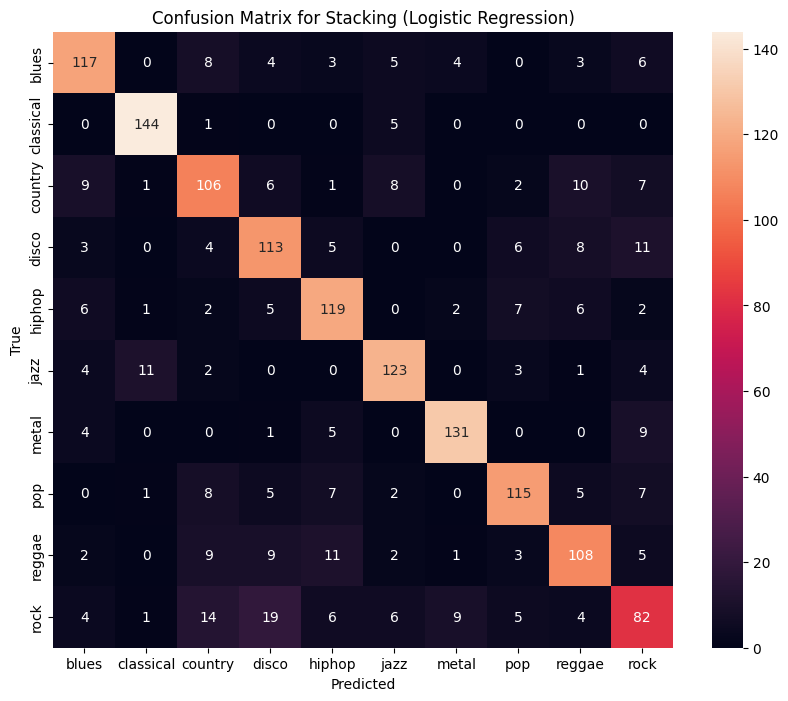

In [ ]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
import librosa
import os
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '/content/drive/MyDrive/data.json'
lstm_model_path = '/content/drive/MyDrive/lstm_vocal_classifier.keras'
cnn_model_path = '/content/drive/MyDrive/cnn_accompaniment_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40
n_frames = 132

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Prepare MFCCs for LSTM/CNN (pad to (40, 132, 1))
X_model = X.copy()
if X_model.shape[1:] == (130, 13):
    print(f"Adjusting MFCCs for LSTM/CNN to (40, 132)...")
    X_model = X_model[:, :40, :]
    X_model = np.pad(X_model, ((0, 0), (0, 0), (0, 132 - X_model.shape[2])), mode='constant')
    X_model = X_model[..., np.newaxis]
    print(f"LSTM/CNN X shape: {X_model.shape}")

# Prepare MFCCs for CRNN (keep (130, 13, 1))
X_crnn = X[..., np.newaxis]
print(f"CRNN X shape: {X_crnn.shape}")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_model_train, X_model_temp, y_train, y_temp = train_test_split(X_model, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_model_val, X_model_test, y_val, y_test = train_test_split(X_model_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_crnn_train, X_crnn_temp = train_test_split(X_crnn, test_size=0.3, random_state=42)
X_crnn_val, X_crnn_test = train_test_split(X_crnn_temp, test_size=0.5, random_state=42)
print(f"Model X_train shape: {X_model_train.shape}, X_val shape: {X_model_val.shape}, X_test shape: {X_model_test.shape}")
print(f"CRNN X_train shape: {X_crnn_train.shape}, X_val shape: {X_crnn_val.shape}, X_test shape: {X_crnn_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_model_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_model_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_model_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
crnn_test_dataset = tf.data.Dataset.from_tensor_slices((X_crnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load or train CNN model
if os.path.exists(cnn_model_path):
    print("Loading trained CNN model...")
    cnn_model = load_model(cnn_model_path)
else:
    print("Training CNN accompaniment classifier...")
    def build_cnn_accompaniment_classifier(input_shape=(40, 132, 1), num_classes=10):
        model = Sequential([
            Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        return model
    cnn_model = build_cnn_accompaniment_classifier()
    cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])
    cnn_model.save(cnn_model_path)

# Load LSTM model
print("Loading trained LSTM model...")
lstm_model = load_model(lstm_model_path)

# Get predictions
print("Generating predictions...")
lstm_probs = lstm_model.predict(X_model_test)  # Assuming same MFCCs for simplicity; ideally use X_vocal_test
cnn_probs = cnn_model.predict(X_model_test)
y_true = y_test

# Bagging: Soft Voting and Mean Averaging
print("Performing bagging...")
# Mean Averaging
mean_probs = (lstm_probs + cnn_probs) / 2
mean_preds = np.argmax(mean_probs, axis=1)
mean_accuracy = np.mean(mean_preds == y_true)
print(f"Bagging (Mean Averaging) Accuracy: {mean_accuracy:.4f}")

# Soft Voting (example weights: 0.3 for LSTM, 0.7 for CNN)
weights = [0.5, 0.5]
soft_probs = weights[0] * lstm_probs + weights[1] * cnn_probs
soft_preds = np.argmax(soft_probs, axis=1)
soft_accuracy = np.mean(soft_preds == y_true)
print(f"Bagging (Soft Voting) Accuracy: {soft_accuracy:.4f}")

# Stacking: Prepare meta-model inputs
stacking_features = np.concatenate([lstm_probs, cnn_probs], axis=1)
print(f"Stacking features shape: {stacking_features.shape}")

# Stacking: Logistic Regression
lr_meta = LogisticRegression(max_iter=1000)
lr_meta.fit(stacking_features, y_true)
lr_preds = lr_meta.predict(stacking_features)
lr_accuracy = np.mean(lr_preds == y_true)
print(f"Stacking (Logistic Regression) Accuracy: {lr_accuracy:.4f}")

# Stacking: XGBoost
xgb_meta = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_meta.fit(stacking_features, y_true)
xgb_preds = xgb_meta.predict(stacking_features)
xgb_accuracy = np.mean(xgb_preds == y_true)
print(f"Stacking (XGBoost) Accuracy: {xgb_accuracy:.4f}")

# Stacking: Dense Neural Network
def build_dense_meta_model(input_shape=(20,), num_classes=10):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model
dense_meta = build_dense_meta_model()
dense_meta.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
dense_meta.fit(stacking_features, y_true, epochs=250, batch_size=32, verbose=1)
dense_preds = np.argmax(dense_meta.predict(stacking_features), axis=1)
dense_accuracy = np.mean(dense_preds == y_true)
print(f"Stacking (Dense NN) Accuracy: {dense_accuracy:.4f}")

# Confusion Matrices
plt.figure(figsize=(10, 8))
cm_lr = confusion_matrix(y_true, lr_preds)
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Stacking (Logistic Regression)')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Verify TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '/content/drive/MyDrive/data.json'
accomp_path = '/content/drive/MyDrive/accompaniment_mfcc.json'
lstm_model_path = '/content/drive/MyDrive/lstm_vocal_classifier.keras'
cnn_model_path = '/content/drive/MyDrive/cnn_accompaniment_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.00051

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
with open(accomp_path, 'r', encoding='utf-8') as f:
    accomp_data = json.load(f)

# Extract MFCCs and labels
mfccs_vocal = data['mfcc']
mfccs_accomp = accomp_data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Vocal MFCCs length: {len(mfccs_vocal)}, Accomp MFCCs length: {len(mfccs_accomp)}, Labels length: {len(labels)}")
min_length = min(len(mfccs_vocal), len(mfccs_accomp), len(labels))
mfccs_vocal = mfccs_vocal[:min_length]
mfccs_accomp = mfccs_accomp[:min_length]
labels = labels[:min_length]
print(f"Aligned Vocal MFCCs length: {len(mfccs_vocal)}, Accomp MFCCs length: {len(mfccs_accomp)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X_vocal = np.array(mfccs_vocal)
X_accomp = np.array(mfccs_accomp)
y = np.array(labels)
print(f"X_vocal shape: {X_vocal.shape}, X_accomp shape: {X_accomp.shape}, y shape: {y.shape}")

# Check for non-finite values
for X, name in [(X_vocal, "Vocal"), (X_accomp, "Accomp")]:
    if not np.isfinite(X).all():
        print(f"Warning: Non-finite values in {name} MFCCs, replacing with zeros")
        X = np.where(np.isfinite(X), X, 0.0)

# Pad/reshape MFCCs
if X_vocal.shape[1:] == (130, 13):
    print("Adjusting Vocal MFCCs to (40, 132)...")
    X_vocal = X_vocal[:, :40, :]
    X_vocal = np.pad(X_vocal, ((0, 0), (0, 0), (0, 132 - X_vocal.shape[2])), mode='constant')
    X_vocal = X_vocal[..., np.newaxis]
    print(f"X_vocal shape: {X_vocal.shape}")

if X_accomp.shape[1:] == (132, 40, 1):  # Adjust based on actual shape
    print("Transposing Accomp MFCCs to (40, 132, 1)...")
    X_accomp = np.transpose(X_accomp, (0, 2, 1, 3)).squeeze(-1)
elif X_accomp.shape[1:] == (130, 13):
    print("Adjusting Accomp MFCCs to (40, 132)...")
    X_accomp = X_accomp[:, :40, :]
    X_accomp = np.pad(X_accomp, ((0, 0), (0, 0), (0, 132 - X_accomp.shape[2])), mode='constant')
    X_accomp = X_accomp[..., np.newaxis]
print(f"X_accomp shape: {X_accomp.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
genre_to_label = {genre: idx for idx, genre in enumerate(genres)}
classical_label = genre_to_label['classical']  # Should be 1

# Train-validation-test split
X_vocal_train, X_vocal_temp, X_accomp_train, X_accomp_temp, y_train, y_temp = train_test_split(
    X_vocal, X_accomp, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)
X_vocal_val, X_vocal_test, X_accomp_val, X_accomp_test, y_val, y_test = train_test_split(
    X_vocal_temp, X_accomp_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"X_vocal_train shape: {X_vocal_train.shape}, X_accomp_train shape: {X_accomp_train.shape}")
print(f"X_vocal_test shape: {X_vocal_test.shape}, X_accomp_test shape: {X_accomp_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_accomp_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_accomp_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_accomp_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Retrain CNN
print("Training CNN accompaniment classifier...")
def build_cnn_accompaniment_classifier(input_shape=(40, 132, 1), num_classes=10):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model
cnn_model = build_cnn_accompaniment_classifier()
cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])
cnn_model.save(cnn_model_path)
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Retrained CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Load LSTM
print("Loading trained LSTM model...")
lstm_model = load_model(lstm_model_path)
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(
    tf.data.Dataset.from_tensor_slices((X_vocal_test, y_test)).batch(batch_size)
)
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.4f}")

# Get predictions
print("Generating predictions...")
lstm_probs = lstm_model.predict(X_vocal_test)
cnn_probs = cnn_model.predict(X_accomp_test)
y_true = y_test

# Bagging
print("Performing bagging...")
mean_probs = (lstm_probs + cnn_probs) / 2
mean_preds = np.argmax(mean_probs, axis=1)
mean_accuracy = accuracy_score(y_true, mean_preds)
print(f"Bagging (Mean Averaging) Accuracy: {mean_accuracy:.4f}")

weights = np.ones((len(y_true), 2)) * 0.5
weights[y_true == classical_label, 0] = 0
weights[y_true == classical_label, 1] = 1
soft_probs = weights[:, 0:1] * lstm_probs + weights[:, 1:2] * cnn_probs
soft_preds = np.argmax(soft_probs, axis=1)
soft_accuracy = accuracy_score(y_true, soft_preds)
print(f"Bagging (Soft Voting) Accuracy: {soft_accuracy:.4f}")

# Stacking
stacking_features = np.concatenate([lstm_probs, cnn_probs], axis=1)
X_stack_train, X_stack_val, y_stack_train, y_stack_val = train_test_split(
    stacking_features, y_true, test_size=0.5, stratify=y_true, random_state=42
)

lr_meta = LogisticRegression(max_iter=1000)
lr_meta.fit(X_stack_train, y_stack_train)
lr_preds = lr_meta.predict(X_stack_val)
lr_accuracy = accuracy_score(y_stack_val, lr_preds)
print(f"Stacking (Logistic Regression) Accuracy: {lr_accuracy:.4f}")

xgb_meta = XGBClassifier(eval_metric='mlogloss')
xgb_meta.fit(X_stack_train, y_stack_train)
xgb_preds = xgb_meta.predict(X_stack_val)
xgb_accuracy = accuracy_score(y_stack_val, xgb_preds)
print(f"Stacking (XGBoost) Accuracy: {xgb_accuracy:.4f}")

def build_dense_meta_model(input_shape=(20,), num_classes=10):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model
dense_meta = build_dense_meta_model()
dense_meta.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
dense_meta.fit(X_stack_train, y_stack_train, epochs=50, batch_size=32, verbose=0)
dense_preds = np.argmax(dense_meta.predict(X_stack_val), axis=1)
dense_accuracy = accuracy_score(y_stack_val, dense_preds)
print(f"Stacking (Dense NN) Accuracy: {dense_accuracy:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_lr = confusion_matrix(y_stack_val, lr_preds)
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Stacking (Logistic Regression)')
plt.show()

Mounted at /content/drive
TensorFlow version: 2.18.0
GPU available: []
Loading data...
Vocal MFCCs length: 9986, Accomp MFCCs length: 499, Labels length: 9986
Aligned Vocal MFCCs length: 499, Accomp MFCCs length: 499, Labels length: 499
X_vocal shape: (499, 130, 13), X_accomp shape: (499, 40, 132, 1), y shape: (499,)
Adjusting Vocal MFCCs to (40, 132)...
X_vocal shape: (499, 40, 132, 1)
X_accomp shape: (499, 40, 132, 1)
X_vocal_train shape: (349, 40, 132, 1), X_accomp_train shape: (349, 40, 132, 1)
X_vocal_test shape: (75, 40, 132, 1), X_accomp_test shape: (75, 40, 132, 1)
Training CNN accompaniment classifier...
Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 871ms/step - accuracy: 0.5658 - loss: 2.9574 - val_accuracy: 1.0000 - val_loss: 7.1684e-07 - learning_rate: 5.1000e-04
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step - accuracy: 0.9941 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.1000e-04
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - accuracy: 1.0000 - loss: 2.8271e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.1000e-04
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 1.0000 - loss: 3.9156e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.1000e-04
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 889ms/step - accuracy: 1.0000 - loss: 8.3301e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.1000e-04
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step - accuracy: 1.0000 - loss: 2.0757e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.1000e-04
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 59

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)